![alt text](params.png "Title")

In [1]:
import pynamod
import torch
import h5py
from pynamod.geometry.trajectories import H5_Trajectory

/home/v_vasilev/.conda/envs/pynamod_env/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)
/home/v_vasilev/.conda/envs/pynamod_env/lib/python3.11/site-packages/ipywidgets/widgets/widget.py:503: DeprecationWarning: The `ipykernel.comm.Comm` class has been deprecated. Please use the `comm` module instead.For creating comms, use the function `from comm import create_comm`.
  self.comm = Comm(**args)


/home/v_vasilev/.conda/envs/pynamod_env/lib/python3.11/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(
/home/v_vasilev/.conda/envs/pynamod_env/lib/python3.11/site-packages/MDAnalysis/topology/PDBParser.py:331: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using MDAnalysis.topology.guessers.
  warnings.warn("Element information is missing, elements attribute "


### Анализ полноатомоных моделей

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
nucl = pynamod.CG_Structure()
file = h5py.File('examples/Nucl_fiber.h5','r')
nucl.load_from_h5(file)

Визуализация

In [4]:
nucl.view_structure()

NGLWidget()

### Генерация линейной ДНК

In [5]:
seq = 'atcg'*4
dna_gen = pynamod.CG_Structure()
dna_gen.build_dna(seq)

In [6]:
dna_gen.view_structure()


NGLWidget()

### Объединение структур

Инициализация стурктуры с белком cas9

In [7]:
cas = pynamod.CG_Structure(pdb_id='5Y36')
cas.analyze_dna(leading_strands=['C'],sel='segid C D')

Sending GET request to https://files.rcsb.org/download/5Y36.pdb to fetch 5Y36's pdb file as a string.


In [8]:
cas.analyze_protein()

In [9]:
cas.view_structure()

NGLWidget()

Объединение с нуклеосомой и линейной ДНК

In [10]:
nucl.append_structures([dna_gen,cas])

In [11]:
nucl.view_structure()

NGLWidget()

### Моделирование методом Монте-Карло

Подготовка расчетов энергий

In [12]:
en = pynamod.Energy(K_bend=1)
en.set_energy_matrices(nucl,ignore_neighbors=20)

In [13]:
movable_steps = torch.zeros(nucl.dna.step_params.shape[0],dtype=bool)
movable_steps[145:161] = True

In [14]:
traj = H5_Trajectory('examples/example_traj.h5',100,182,200,attrs_names=['prot_origins'])

Запуск моделирования

In [15]:
intg = pynamod.Iterator(nucl,en,traj,sigma_rot=0.1,sigma_transl=0.1)

In [16]:
intg.run(movable_steps,target_accepted_steps=1000,max_steps=10000,device='cuda',KT_factor=1.5,save_every=1,transfer_to_memory_every=100)

Steps:   0%|          | 0/10000 [00:00<?, ?it/s]

Acceptance rate:   0%|          

Starting time: 04/21/25 16:19:04
target accepted steps reached
Finish time: 04/21/25 16:19:14
accepted steps: 1000
total steps: 1208


In [17]:
nucl.dna.geom_params.trajectory = traj

In [18]:
u = nucl.get_cg_mda_traj()

In [19]:
import nglview as nv
v = nv.show_mdanalysis(u)
v.clear()
v.add_representation('spacefill',radius =5)
v

NGLWidget(max_frame=1099)

In [20]:
import matplotlib.pyplot as plt

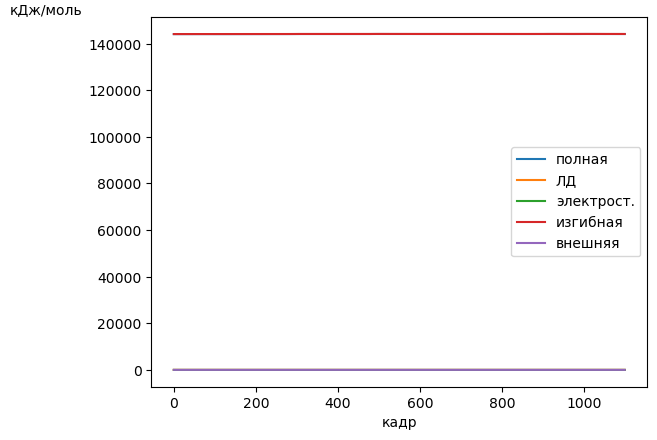

In [21]:
sl = slice(0,None,1)
plt.plot(traj.get_energy_array_slice('total',sl),label='полная')
plt.plot(traj.get_energy_array_slice('ld',sl),label='ЛД')
plt.plot(traj.get_energy_array_slice('elst',sl),label='электрост.')
plt.plot(traj.get_energy_array_slice('bend',sl),label='изгибная')
plt.plot(traj.get_energy_array_slice('restr',sl),label='внешняя')
plt.xlabel('кадр')
plt.ylabel('кДж/моль', rotation=0,loc='top')
plt.legend()

In [22]:
traj.total_energies

array([144112.70694726, 144111.83960494, 144114.04003081, ...,
       144149.50698113, 144150.00354239, 144151.32998678])